## Web Scraping

In [ ]:
from time import sleep
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,mean_absolute_error

In [ ]:
df = pd.DataFrame()

features = [
    'Company',
    'Product',
    'TypeName',
    'Inches',
    'Resolution',
    'CPU',
    'RAM',
    'Memory',
    'Gpu',
    'OpSys',
    'weight',
    'Price',
    
    
]

 Inches	ScreenResolution	Cpu	Ram	Memory	Gpu	OpSys	Weight	Price_euros

GPU Characteristics Operating System Laptop's Weight Laptop's Price
pages_count = 26  # scrolls down count  
driver = webdriver.Chrome(executable_path='/Users/shatha_almoteb/Downloads/chromedriver')  # initiate the browser
driver.get('https://www.jarir.com/sa-en/computers-peripherals/laptops.html')  # open url with intiated browser
sleep(3)


In [ ]:
 scroll down for 26 times and click the load more button
for i in range(pages_count):
    driver.execute_script("window.scrollTo(0,document.body.scrollHeight - 1000)")
    sleep(1)
    try:
        button = driver.find_elements_by_class_name('amscroll-load-button')[0]
       
        button.click()
        
    except IndexError:  # button not exists, (pages ended)
        break  # stop the loop
    sleep(2)

In [ ]:
html = driver.page_source  # get htnl source to pass html source to bs4 
response = BeautifulSoup(html,'html.parser')  # pass html code to bs4

def collect_product_data(url):
    print(url) # print the url of product
    product_data = {} # initiate product data key-value more easy to access product data 
    for f in features: # initiate the product data features
        product_data[f] = ''
    driver.get(url) # open product url
    resp = BeautifulSoup(driver.page_source, 'html.parser') # pass product source page to bs4
    # assign values to product keys
    #product_data['brand'] = resp.find('div', attrs={'class': 'product-title__brand'}).text.strip('\n').strip()
    product_data['title'] = resp.find('h1', attrs={'class': 'product-title__title'}).text.strip('\n').strip()
    try:
        product_data['price'] = round(float(resp.find('meta', attrs={'itemprop': 'price'})['content']), 2)
    # some products have no content attribute , so we used an exception here
    except TypeError:
        try:
            # get the price from text of html tag, not from it's attribute (content)
            product_data['price'] = round(float(resp.find('div', attrs={'class': 'price'}).text.strip('\n').strip().replace('SR', '')), 2)
        # some products has no price so we put it as -  
        except AttributeError:
            product_data['price'] = '-'
    # get products rows data , each row has no (ID) for the tag , so we cant get the specific info
    # we get all info and then check if this infos exists in our featrue list that we initiate above
    rows_info = resp.find_all('tr', attrs={'class': 'table__row'})
    for i in rows_info:
        info_title = i.find('th').text.strip('\n').strip().replace(' ', '_')
        info_value = i.find('td').text.strip('\n').strip()
        if(info_title in features):
            product_data[info_title] = info_value
    #return the dictionary has all product infos
    return product_data

In [ ]:
def add_to_df(product):
    global df
    df = df.append(product, ignore_index=True)

In [ ]:
for url in urls:
    add_to_df(collect_product_data(url))
    sleep(5)
    

In [ ]:
df.to_csv('laptops.csv', encoding='utf-8-sig', index=False)
driver.close()

## Data Cleaning 

1. Remove extra unnecessary details form Product Columns
2. Extract CPU Vender, CPU Type and CPU Speed in Different Columns
3. Convert Ram into Numeric Values
4. Extract Memory type from Memory Column
5. Convert Weight into numeric Values
6. Extract GPU Vender, GPU Type in Different Columns
7. Extract IPS and Touchscreen Feature form ScreenResolution Column

In [32]:
df_laptops=pd.read_csv("laptops.csv")
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [33]:
df_laptops["Product"] = df_laptops["Product"].str.split("(").apply(lambda x: x[0])

In [34]:
df_laptops["Cpu_Speed"] = df_laptops["Cpu"].str.split(" ").apply(lambda x: x[-1]).str.replace("GHz", "")
df_laptops["Cpu_Vender"] = df_laptops["Cpu"].str.split(" ").apply(lambda x: x[0])
df_laptops["Cpu_Type"] = df_laptops["Cpu"].str.split(" ").apply(lambda x: x[1:4] if x[1] == "Celeron" and "Pentium" and "Xeon" else (x[1:3] if (x[1] == "Core" or x[0] == "AMD") else x[0]) )
df_laptops["Cpu_Type"] = df_laptops["Cpu_Type"].apply(lambda x: ' '.join(x))
df_laptops["Cpu_Type"]
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Cpu_Speed,Cpu_Vender,Cpu_Type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2.3,Intel,Core i5
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1.8,Intel,Core i5
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,2.5,Intel,Core i5
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2.7,Intel,Core i7
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,3.1,Intel,Core i5


In [35]:
split_mem = df_laptops['Memory'].str.split(' ', 1, expand=True)
df_laptops['Storage Type'] = split_mem[1]
df_laptops['Memory'] = split_mem[0]
df_laptops["Memory"].unique()
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Cpu_Speed,Cpu_Vender,Cpu_Type,Storage Type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2.3,Intel,Core i5,SSD
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB,Intel HD Graphics 6000,macOS,1.34kg,898.94,1.8,Intel,Core i5,Flash Storage
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB,Intel HD Graphics 620,No OS,1.86kg,575.00,2.5,Intel,Core i5,SSD
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2.7,Intel,Core i7,SSD
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,3.1,Intel,Core i5,SSD


In [36]:
df_laptops["Ram"] = df_laptops["Ram"].str.replace("GB", "")

df_mem= df_laptops['Memory'].str.split('(\d+)',  expand=True)
df_laptops['Memory'] = pd.to_numeric(df_mem[1])
df_laptops.rename(columns={'Memory':'Memory (GB or TB)'}, inplace=True)

def mem(x):
    if x == 1:
        return 1024
    elif x == 2:
        return 2048
df_laptops['Memory (GB or TB)'] = df_laptops['Memory (GB or TB)'].apply(lambda x: 1024 if x==1 else x)
df_laptops['Memory (GB or TB)'] = df_laptops['Memory (GB or TB)'].apply(lambda x: 2048 if x==2 else x)
df_laptops.rename(columns={'Memory (GB or TB)':'Storage (GB)'}, inplace=True)
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Storage (GB),Gpu,OpSys,Weight,Price_euros,Cpu_Speed,Cpu_Vender,Cpu_Type,Storage Type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2.3,Intel,Core i5,SSD
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34kg,898.94,1.8,Intel,Core i5,Flash Storage
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86kg,575.00,2.5,Intel,Core i5,SSD
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2.7,Intel,Core i7,SSD
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,3.1,Intel,Core i5,SSD


In [37]:
df_laptops["Weight"] = df_laptops["Weight"].str.replace("kg", "")
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Storage (GB),Gpu,OpSys,Weight,Price_euros,Cpu_Speed,Cpu_Vender,Cpu_Type,Storage Type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2.3,Intel,Core i5,SSD
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,1.8,Intel,Core i5,Flash Storage
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,2.5,Intel,Core i5,SSD
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83,2537.45,2.7,Intel,Core i7,SSD
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,3.1,Intel,Core i5,SSD


In [38]:
gpu_distribution_list = df_laptops["Gpu"].str.split(" ")
#data["Gpu_Vender"] = data["Gpu"].str.split(" ").apply(lambda x: x[0:2]  if x[0] == "Intel" else x[0]  if x[0] == "Intel Iris" else x[0])
df_laptops["Gpu_Vender"] = df_laptops["Gpu"].str.split(" ").apply(lambda x: x[0])
df_laptops["Gpu_Type"] = df_laptops["Gpu"].str.split(" ").apply(lambda x: x[1:])
df_laptops["Gpu_Type"] = df_laptops["Gpu_Type"].apply(lambda x: ' '.join(x))
df_laptops.head()



,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Storage (GB),Gpu,OpSys,Weight,Price_euros,Cpu_Speed,Cpu_Vender,Cpu_Type,Storage Type,Gpu_Vender,Gpu_Type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2.3,Intel,Core i5,SSD,Intel,Iris Plus Graphics 640
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,1.8,Intel,Core i5,Flash Storage,Intel,HD Graphics 6000
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,2.5,Intel,Core i5,SSD,Intel,HD Graphics 620
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512,AMD Radeon Pro 455,macOS,1.83,2537.45,2.7,Intel,Core i7,SSD,AMD,Radeon Pro 455
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,3.1,Intel,Core i5,SSD,Intel,Iris Plus Graphics 650


In [39]:
df_laptops['Touchscreen'] = df_laptops['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
df_laptops['Ips'] = df_laptops['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

In [40]:
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'

df_laptops['OpSys'] = df_laptops['OpSys'].apply(cat_os)

In [41]:
df_laptops2 = df_laptops.reindex(columns=["Company", "TypeName", "Inches", "Touchscreen", "Ips", "Cpu_Vender", 
                             "Cpu_Type","Ram", "Storage (GB)",
                             "Storage Type", "Gpu_Vender", "Gpu_Type", 
                             "Weight", "OpSys", "Price_euros" ])

In [42]:
df_laptops2.head()

,Company,TypeName,Inches,Touchscreen,Ips,Cpu_Vender,Cpu_Type,Ram,Storage (GB),Storage Type,Gpu_Vender,Gpu_Type,Weight,OpSys,Price_euros
0,Apple,Ultrabook,13.3,0,1,Intel,Core i5,8,128,SSD,Intel,Iris Plus Graphics 640,1.37,Mac,1339.69
1,Apple,Ultrabook,13.3,0,0,Intel,Core i5,8,128,Flash Storage,Intel,HD Graphics 6000,1.34,Mac,898.94
2,HP,Notebook,15.6,0,0,Intel,Core i5,8,256,SSD,Intel,HD Graphics 620,1.86,Others/No OS/Linux,575.00
3,Apple,Ultrabook,15.4,0,1,Intel,Core i7,16,512,SSD,AMD,Radeon Pro 455,1.83,Mac,2537.45
4,Apple,Ultrabook,13.3,0,1,Intel,Core i5,8,256,SSD,Intel,Iris Plus Graphics 650,1.37,Mac,1803.60


In [43]:
df_laptops2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1303 non-null   object 
 1   TypeName      1303 non-null   object 
 2   Inches        1303 non-null   float64
 3   Touchscreen   1303 non-null   int64  
 4   Ips           1303 non-null   int64  
 5   Cpu_Vender    1303 non-null   object 
 6   Cpu_Type      1303 non-null   object 
 7   Ram           1303 non-null   object 
 8   Storage (GB)  1303 non-null   int64  
 9   Storage Type  1303 non-null   object 
 10  Gpu_Vender    1303 non-null   object 
 11  Gpu_Type      1303 non-null   object 
 12  Weight        1303 non-null   object 
 13  OpSys         1303 non-null   object 
 14  Price_euros   1303 non-null   float64
dtypes: float64(2), int64(3), object(10)
memory usage: 152.8+ KB


In [44]:
df_laptops2["Ram"] = df_laptops2["Ram"].astype("int")
df_laptops2["Storage (GB)"] = df_laptops2["Storage (GB)"].astype("int")
df_laptops2["Weight"] = df_laptops2["Weight"].astype("float")

## Exploratory Data Analysis

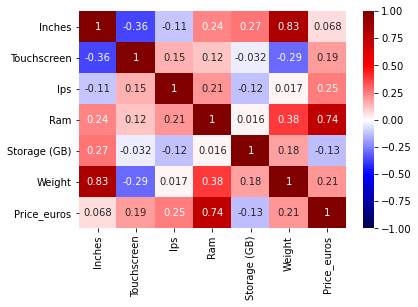

In [45]:
sns.heatmap(df_laptops2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

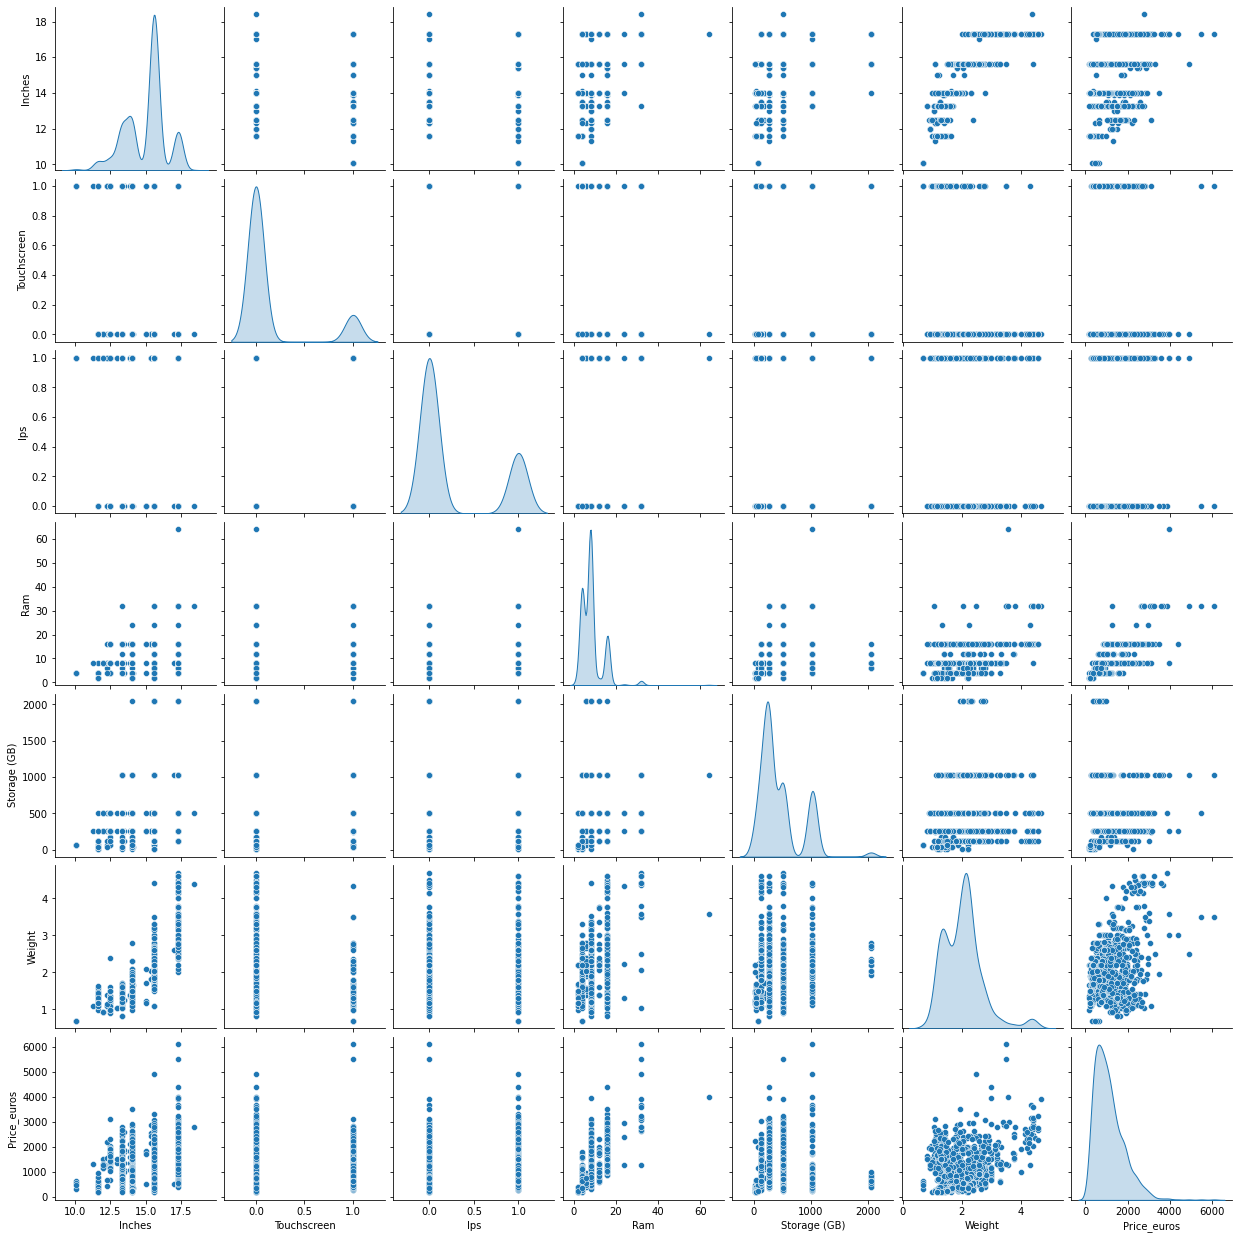

In [46]:
sns.pairplot(df_laptops2, diag_kind='kde')
plt.show()

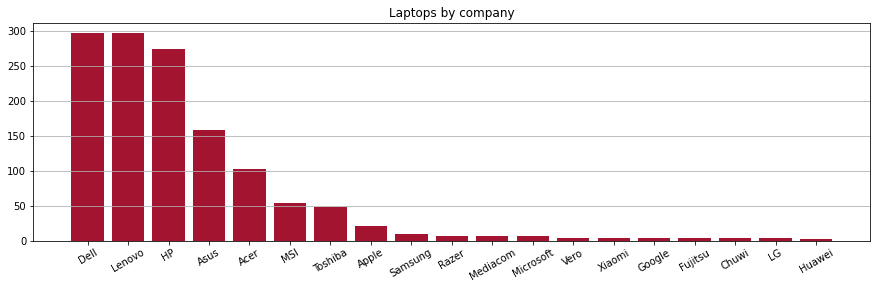

In [47]:
comp = df_laptops.groupby(['Company']).count().reset_index().sort_values(by='Unnamed: 0', ascending=False)
plt.figure(figsize=(15,4))
plt.bar(comp['Company'], comp['Unnamed: 0'], color=	'#A2142F')
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.title('Laptops by company')
plt.show()

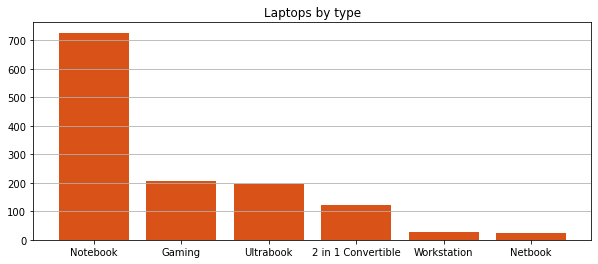

In [48]:
tn = df_laptops.groupby(['TypeName']).count().reset_index().sort_values(by='Unnamed: 0', ascending=False)
plt.figure(figsize=(10,4))
plt.bar(tn['TypeName'], tn['Unnamed: 0'], color='#D95319')
plt.title('Laptops by type')
plt.grid(axis='y')
plt.show()

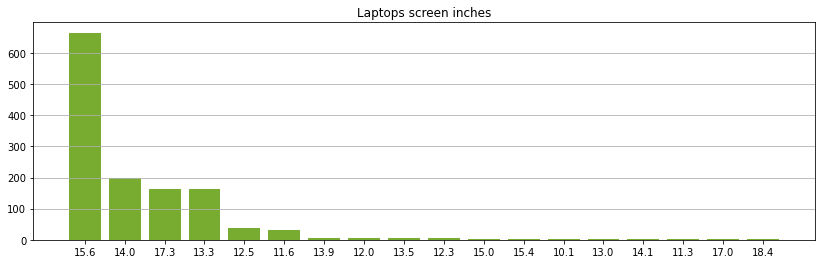

In [49]:
df_laptops['Inches'] = df_laptops['Inches'].astype(str)
inc = df_laptops.groupby(['Inches']).count().reset_index().sort_values(by='Unnamed: 0', ascending=False)
plt.figure(figsize=(14,4))
plt.bar(inc['Inches'], inc['Unnamed: 0'], color='#77AC30')
plt.title('Laptops screen inches')
plt.grid(axis='y')
plt.show()

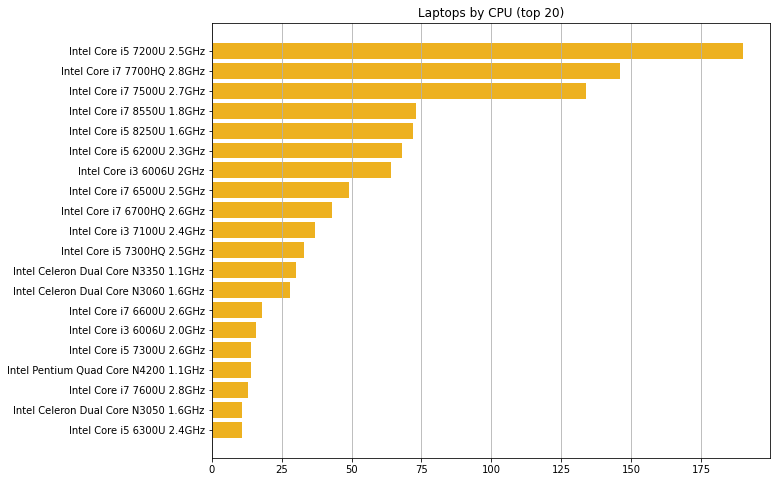

In [50]:
cpu = df_laptops.groupby(['Cpu']).count().reset_index().sort_values(by='Unnamed: 0', ascending=True).tail(20)
plt.figure(figsize=(10,8))
plt.barh(cpu['Cpu'], cpu['Unnamed: 0'], color='#EDB120')
plt.title('Laptops by CPU (top 20)')
plt.grid(axis='x')
plt.show()

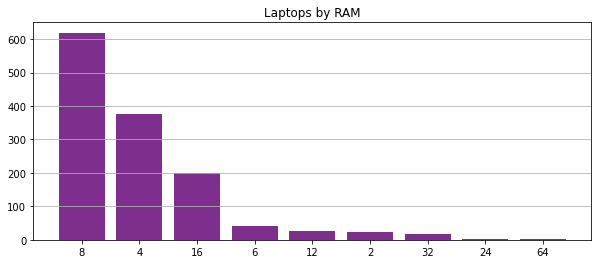

In [51]:
ram = df_laptops.groupby(['Ram']).count().reset_index().sort_values(by='Unnamed: 0', ascending=False)
plt.figure(figsize=(10,4))
plt.bar(ram['Ram'], ram['Unnamed: 0'], color='#7E2F8E')
plt.title('Laptops by RAM')
plt.grid(axis='y')
plt.show()

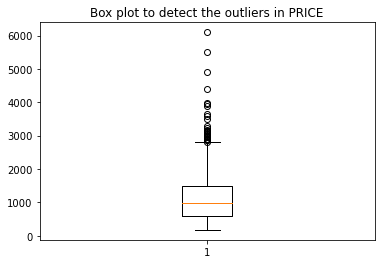

In [52]:
plt.boxplot(df_laptops2["Price_euros"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

/Users/shatha_almoteb/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


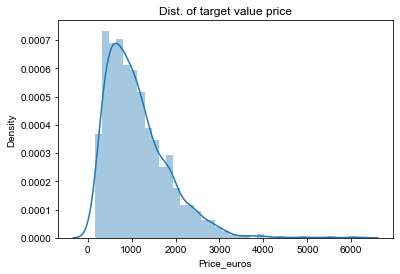

In [53]:
sns.distplot(df_laptops2['Price_euros']).set(title='Dist. of target value price')
sns.set(rc={"figure.figsize":(12, 12)})

In [54]:
df_laptops2.describe()

,Inches,Touchscreen,Ips,Ram,Storage (GB),Weight,Price_euros
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,15.017191,0.147352,0.280123,8.382195,447.809670,2.038734,1123.686992
std,1.426304,0.354593,0.449231,5.084665,366.037159,0.665475,699.009043
min,10.100000,0.000000,0.000000,2.000000,8.000000,0.690000,174.000000
25%,14.000000,0.000000,0.000000,4.000000,256.000000,1.500000,599.000000
50%,15.600000,0.000000,0.000000,8.000000,256.000000,2.040000,977.000000
75%,15.600000,0.000000,1.000000,8.000000,512.000000,2.300000,1487.880000
max,18.400000,1.000000,1.000000,64.000000,2048.000000,4.700000,6099.000000


## Modeling

In [55]:
y = df_laptops2['Price_euros']

X = df_laptops2[['Ram', 'Inches','Touchscreen','Ips','Storage (GB)']]


### scaling

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # setting with_mean False, is for a reason !

temp = scaler.fit_transform(X)
X = pd.DataFrame(temp)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Linear Regression

In [57]:
lr = LinearRegression() 

In [58]:
lr.fit(X_train,y_train)
lr.score(X_train,y_train) # train-set score

0.6020371837065092

In [59]:
lr.score(X_test,y_test) # test-set score

0.538879372134778

In [60]:
y_pred_lr = lr.predict(X_test) # prediction 

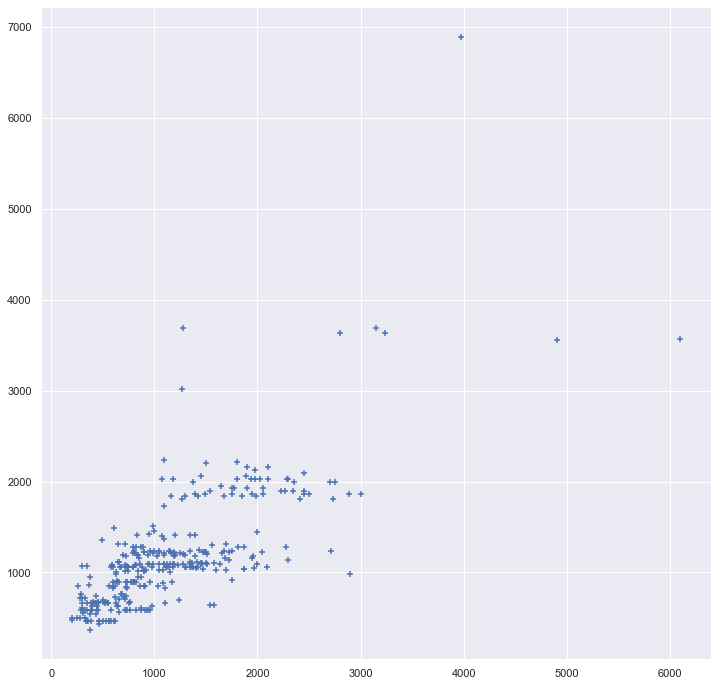

In [61]:
plt.scatter(y_test, y_pred_lr, marker='+')

In [62]:
print('R2 test score',r2_score(y_test,y_pred_lr))
print('MAE',mean_absolute_error(y_pred_lr,y_test))
print('MSE',mean_squared_error(y_pred_lr,y_test))
print('RMSE',np.sqrt(mean_squared_error(y_pred_lr,y_test)))

R2 test score 0.538879372134778
MAE 343.4760447496269
MSE 245240.39265588537
RMSE 495.21752054615894


### Random Forest Regressor

In [63]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=1)

In [64]:
rfr.fit(X_train,y_train)

rfr.score(X_train,y_train) # train-set score 

0.7993377551742553

In [65]:
rfr.score(X_test,y_test) # test-set score

0.6810317375314294

In [66]:
y_pred_rfr = rfr.predict(X_test) #prediction

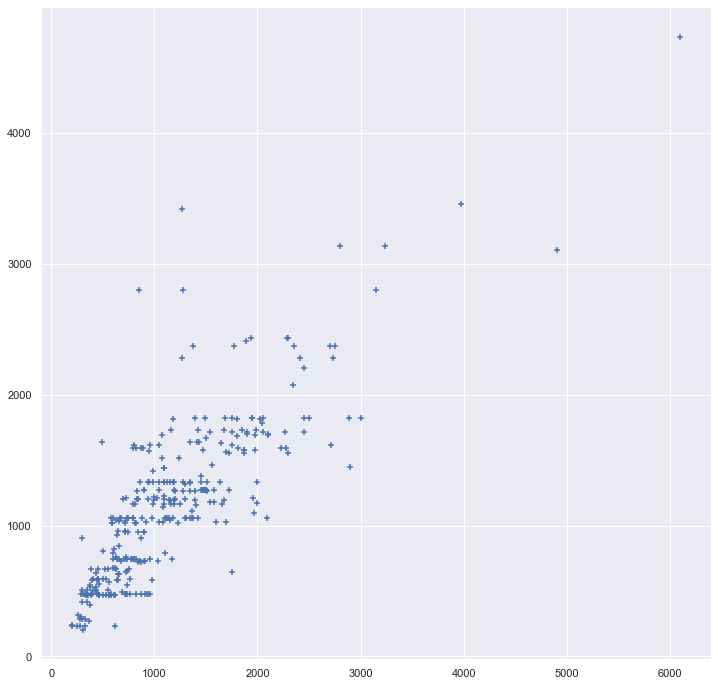

In [67]:
plt.scatter(y_test, y_pred_rfr, marker='+')

In [68]:
mean_absolute_error(y_pred_rfr,y_test)


280.78944312279526

In [69]:
print('R2 test score',r2_score(y_test,y_pred_rfr))

R2 test score 0.6810317375314294


### Ploynomial

In [70]:
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)


0.6375125407489124

In [71]:
lr_poly.score(X_test_poly,y_test)

0.6013665593292908

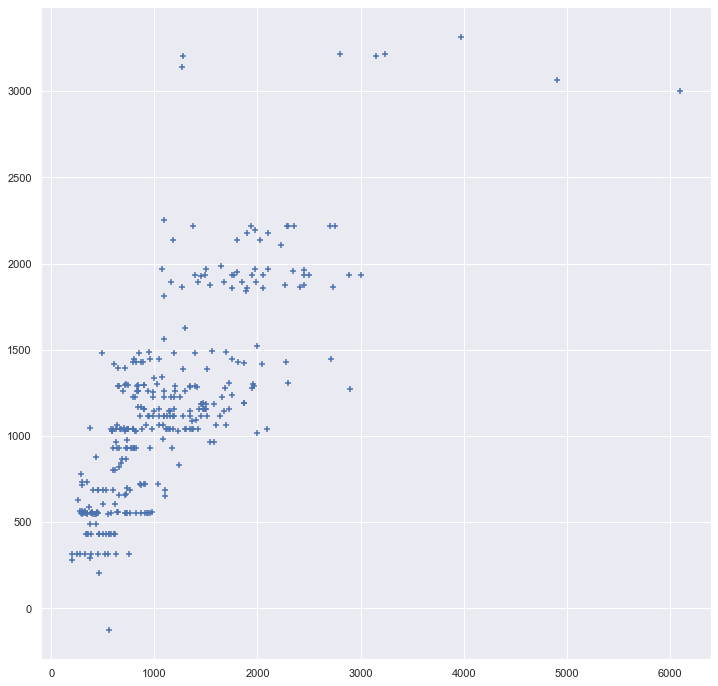

In [72]:
predictions = lr_poly.predict(X_test_poly)
plt.scatter(y_test, predictions, marker='+')

In [73]:
print('R2 test score',r2_score(y_test,predictions))

R2 test score 0.6013665593292908


In [74]:
mean_absolute_error(predictions,y_test)

327.09225076687113